In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import sys
sys.path.append(r'C:\Users\acostamendoza\projects\Grid-orientation-project\src')
import os
from GridMetrics import GridScorer, circle_mask, get_even_odd_times, GridParameters, create_new_result_dir, load_grid_metrics_from_pickle
import json
import random
import scipy
from skimage.feature import peak_local_max
%load_ext autoreload
%autoreload 2

# Set default parameters for matplotlib
plt.rcParams.update({
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14, 
    'axes.titlesize': 16,
    'legend.fontsize': 12,
})

In [24]:
rat = 'r1'
mod = '2'
fig_directory  = r'C:\Users\acostamendoza\Box\grid-cell-project\review-time-vs-variability'

In [3]:
G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)
    
with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
    cell_trial_dict = json.load(f)

Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists


# Get between variability

In [4]:
 accepted = []
    
for cell in cell_trial_dict:
    none_trials = 0
    for trial in cell_trial_dict[cell]:
        if cell_trial_dict[cell][trial]['spacing_odd'] is None:
            none_trials += 1
        elif cell_trial_dict[cell][trial]['spacing_even'] is None:
            none_trials += 1
            
    if none_trials <= 5:
        accepted.append(cell)

In [5]:
def get_time_chunks(number_of_chunks):
    
    length_of_recording = len(G.x)
    half_recording = int(length_of_recording/2)
    
    time_vector = [True]*half_recording + [False]*int(length_of_recording-half_recording)
     # if length of recording is odd, add one more False
    # compare with the length of the recording
    if length_of_recording > len(time_vector):
        time_vector.append(False)
    
    shifts = np.linspace(0, length_of_recording - half_recording, number_of_chunks)
    
    time_chunks = []
    for shift in shifts:
        time_chunk = np.roll(time_vector, int(shift))
        time_chunks.append(time_chunk)
        
    return time_chunks
        
def get_mean_and_std_of_time_chunk(number_of_chunks):
    
    time_chunks = get_time_chunks(number_of_chunks)
    
    orientation_mean = []
    orientation_std = []
    
    spacing_mean = []
    spacing_std = []
    
    for time_chunk in time_chunks:
        
        x_chunk = G.x[time_chunk]
        y_chunk = G.y[time_chunk]
        spikes_chunk = []
        for cell in range(G.n_neurons):
            spikes_chunk.append(G.spikes[cell][time_chunk])

        Scorer = GridScorer(x_chunk, y_chunk, spikes_chunk)

        orientations = []
        spacings = []
        
        for cell in accepted:
            sac = Scorer.calculate_sac(int(cell))
            spacing, orientation , _ = G.get_spacing_orientation_and_score(sac)

            if orientation is None:
                continue

            orientations.append(orientation)
            spacings.append(spacing)
            
        orientation_mean.append(np.mean(orientations))
        orientation_std.append(np.std(orientations))
        
        spacing_mean.append(np.mean(spacings))
        spacing_std.append(np.std(spacings))
        
    return orientation_mean, orientation_std, spacing_mean, spacing_std

In [6]:
# plot them both with respect to time
rats = ['r1']
mods = ['2']
orientation_mean_sessions = []
orientation_std_sessions = []
spacing_mean_sessions = []
spacing_std_sessions = []

for rat, mod in zip(rats, mods): 
    
    print('Rat: ', rat, 'Mod: ', mod)
    
    G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)
    
    with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
        cell_trial_dict = json.load(f)
    accepted = []
    
    for cell in cell_trial_dict:
        none_trials = 0
        for trial in cell_trial_dict[cell]:
            if cell_trial_dict[cell][trial]['spacing_odd'] is None:
                none_trials += 1
            elif cell_trial_dict[cell][trial]['spacing_even'] is None:
                none_trials += 1
                
        if none_trials <= 5:
            accepted.append(cell)    
    
    orientation_mean, orientation_std, spacing_mean, spacing_std = get_mean_and_std_of_time_chunk(50)

    orientation_mean_sessions.append(orientation_mean)
    orientation_std_sessions.append(orientation_std)
    spacing_mean_sessions.append(spacing_mean)
    spacing_std_sessions.append(spacing_std)

Rat:  r1 Mod:  2
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists


C:\Users\acostamendoza\projects\Grid-orientation-project\src\GridMetrics.py:226: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


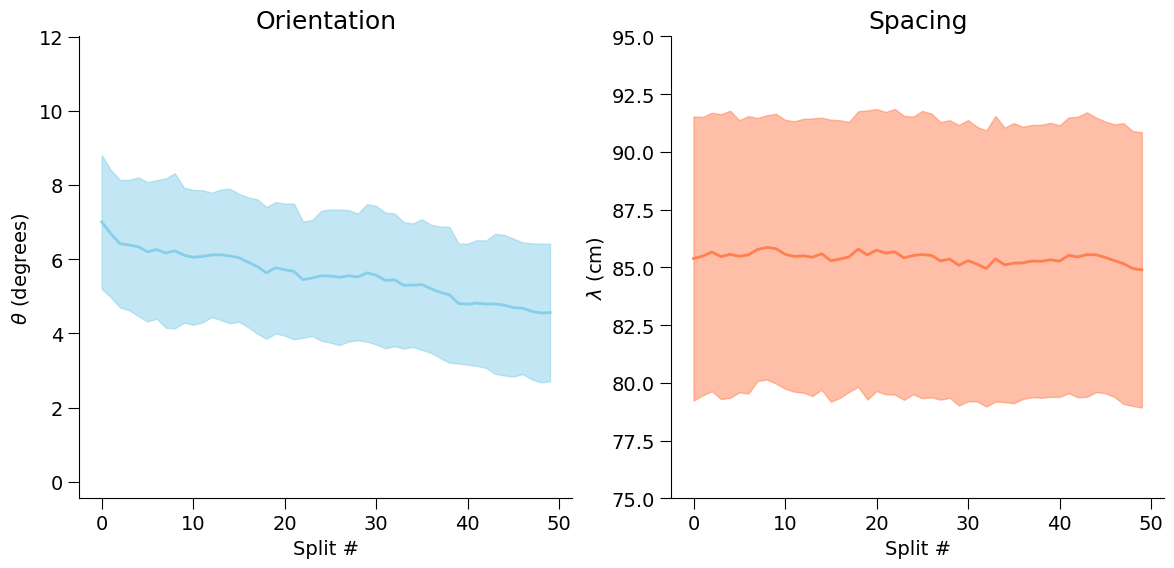

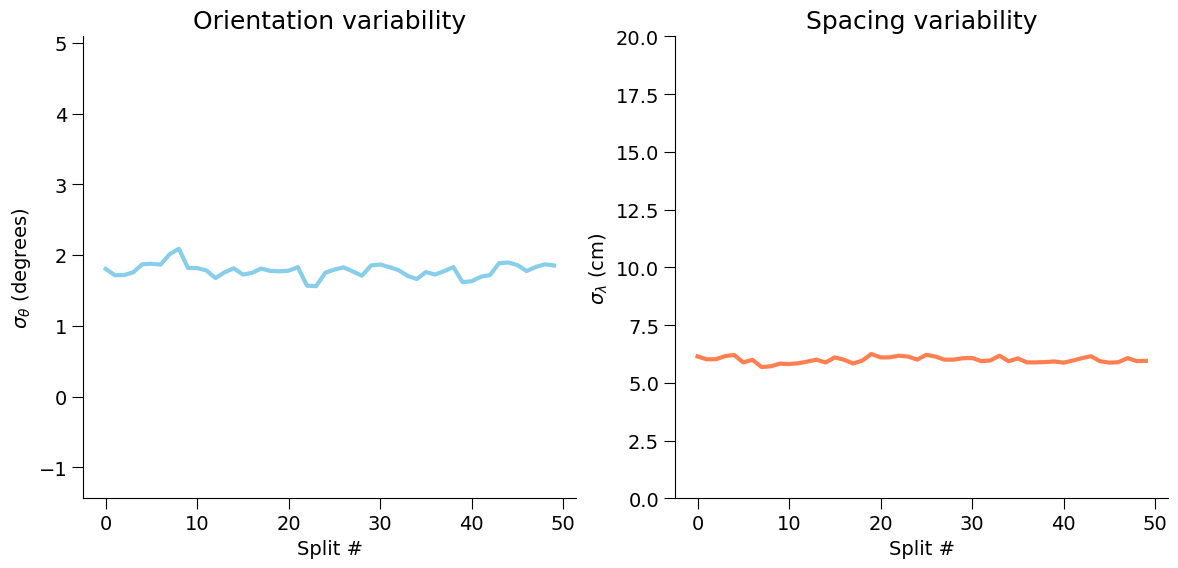

In [17]:
_, ax = plt.subplots(1, 2, figsize=(14, 6))
    
ax[0].plot(orientation_mean, color='skyblue', linewidth=2)
ax[0].fill_between(range(len(orientation_mean)), np.array(orientation_mean) - np.array(orientation_std), np.array(orientation_mean) + np.array(orientation_std), alpha=0.5, color='skyblue')
ax[0].set_title('Orientation', fontsize=18)
ax[0].set_ylim([np.min(orientation_mean) - 5, np.max(orientation_mean) + 5])
ax[0].set_xlabel('Split #', fontsize=14)
ax[0].set_ylabel(r'$\theta$ (degrees)', fontsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].plot(spacing_mean, color='coral', linewidth=2)
ax[1].fill_between(range(len(spacing_mean)), np.array(spacing_mean) - np.array(spacing_std), np.array(spacing_mean) + np.array(spacing_std), alpha=0.5, color='coral')
ax[1].set_title('Spacing', fontsize=18)
ax[1].set_ylim([75, 95])
ax[1].set_xlabel('Split #', fontsize=14)
ax[1].set_ylabel(r'$\lambda$ (cm)', fontsize=14)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# plt.savefig(fig_directory + '/' + rat + mod + '_time-change.png', dpi=300)
# plt.close()
    
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# plot std
ax[0].plot(orientation_std, color='skyblue', linewidth=3)
ax[0].set_title(r'Orientation variability', fontsize=18)
# set limits
ax[0].set_ylim([np.min(orientation_std) - 3, np.max(orientation_std) + 3])
ax[0].set_ylabel(r'$\sigma_{\theta}$ (degrees)', fontsize=14)
ax[0].set_xlabel('Split #', fontsize=14)
# get rid of splines
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].plot(spacing_std, color='coral', linewidth=3)
ax[1].set_title('Spacing variability', fontsize=18)
ax[1].set_ylabel(r'$\sigma_{\lambda}$ (cm)', fontsize=14)
ax[1].set_xlabel('Split #', fontsize=14)
# set limits
ax[1].set_ylim([0, 20])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

Slope orientation:  [-7.40083223e-04  1.80256060e+00]
Slope spacing:  [-7.40083223e-04  1.80256060e+00]


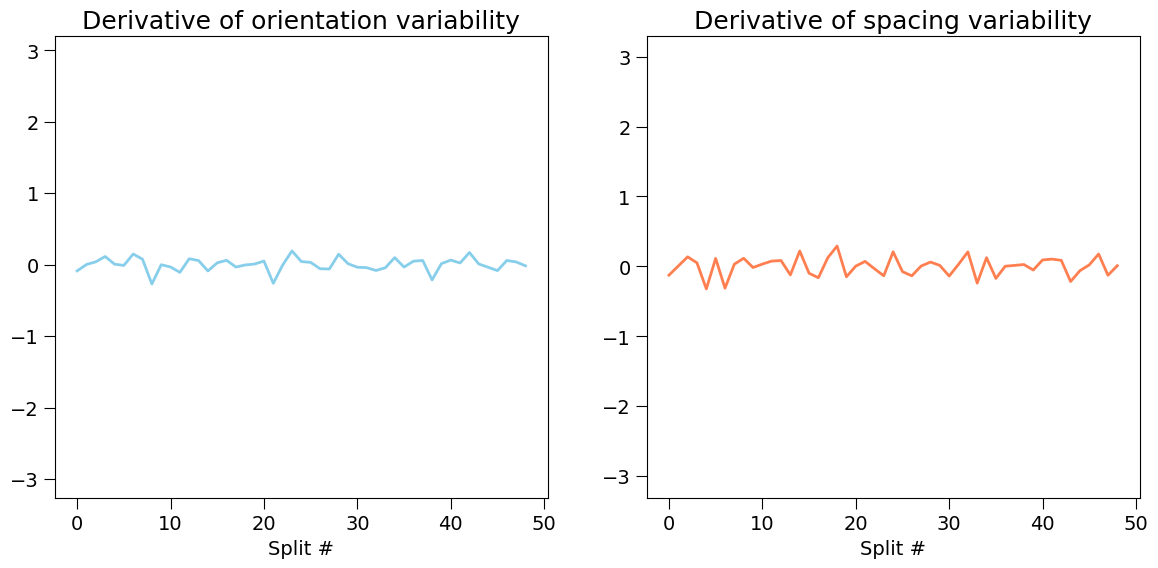

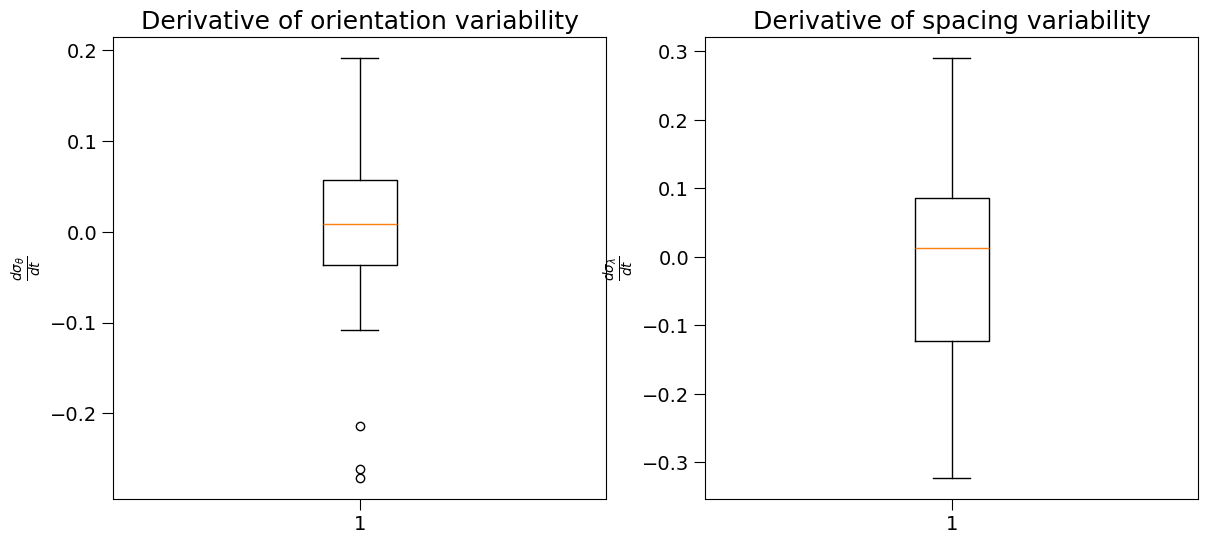

In [13]:
# fit a line to orientation std and spacing std

slope_orientation = np.polyfit(range(len(orientation_std)), orientation_std, 1)
slope_spacing = np.polyfit(range(len(spacing_std)), orientation_std, 1)

# differentate orientation_sdt with respect to time
derivative_orientation_std = np.diff(orientation_std)
derivative_spacing_std = np.diff(spacing_std)

# plot the derivatives
_, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(derivative_orientation_std, color='skyblue', linewidth=2)
ax[0].set_title('Derivative of orientation variability', fontsize=18)
ax[0].set_xlabel('Split #', fontsize=14)
ax[0].set_ylim([np.min(derivative_orientation_std) - 3, np.max(derivative_orientation_std) + 3])

ax[1].plot(derivative_spacing_std, color='coral', linewidth=2)
ax[1].set_title('Derivative of spacing variability', fontsize=18)
ax[1].set_xlabel('Split #', fontsize=14)
ax[1].set_ylim([np.min(derivative_spacing_std) - 3, np.max(derivative_spacing_std) + 3])

## make a boxplot with all the derivates values
_, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].boxplot(derivative_orientation_std)
ax[0].set_title('Derivative of orientation variability', fontsize=18)
ax[0].set_ylabel(r'$\frac{d\sigma_{\theta}}{dt}$', fontsize=14)

ax[1].boxplot(derivative_spacing_std)
ax[1].set_title('Derivative of spacing variability', fontsize=18)
ax[1].set_ylabel(r'$\frac{d\sigma_{\lambda}}{dt}$', fontsize=14)

print('Slope orientation: ', slope_orientation)
print('Slope spacing: ', slope_spacing)

In [17]:
np.save(fig_directory + r'\\' + rat + mod + '_orientation_mean.npy', orientation_mean)
np.save(fig_directory + r'\\' + rat + mod + '_orientation_std.npy', orientation_std)
np.save(fig_directory + r'\\' + rat + mod + '_spacing_mean.npy', spacing_mean)
np.save(fig_directory + r'\\' + rat + mod + '_spacing_std.npy', spacing_std)

In [22]:
# plot them both with respect to time
rats = ['q', 'q', 'r1', 'r1', 'r1', 's', 'r2', 'r2']
mods = ['1', '2', '1', '2', '3', '1', '1', '2']
orientation_mean_sessions = []
orientation_std_sessions = []
spacing_mean_sessions = []
spacing_std_sessions = []

for rat, mod in zip(rats, mods): 
    
    print('Rat: ', rat, 'Mod: ', mod)
    
    G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)
    
    with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
        cell_trial_dict = json.load(f)
    accepted = []
    
    for cell in cell_trial_dict:
        none_trials = 0
        for trial in cell_trial_dict[cell]:
            if cell_trial_dict[cell][trial]['spacing_odd'] is None:
                none_trials += 1
            elif cell_trial_dict[cell][trial]['spacing_even'] is None:
                none_trials += 1
                
        if none_trials <= 5:
            accepted.append(cell)    
    
    orientation_mean, orientation_std, spacing_mean, spacing_std = get_mean_and_std_of_time_chunk(25)

    orientation_mean_sessions.append(orientation_mean)
    orientation_std_sessions.append(orientation_std)
    spacing_mean_sessions.append(spacing_mean)
    spacing_std_sessions.append(spacing_std)
    
    # save the results in npy files
    np.save(fig_directory + '/' + rat + mod + '_orientation_mean.npy', orientation_mean)
    np.save(fig_directory + '/' + rat + mod + '_orientation_std.npy', orientation_std)
    np.save(fig_directory + '/' + rat + mod + '_spacing_mean.npy', spacing_mean)
    np.save(fig_directory + '/' + rat + mod + '_spacing_std.npy', spacing_std)

Rat:  q Mod:  1
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\q1 already exists


C:\Users\acostamendoza\projects\Grid-orientation-project\src\GridMetrics.py:226: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


Rat:  q Mod:  2
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\q2 already exists
Rat:  r1 Mod:  1
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r11 already exists
Rat:  r1 Mod:  2
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists
Rat:  r1 Mod:  3
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r13 already exists
Rat:  s Mod:  1
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\s1 already exists
Rat:  r2 Mod:  1
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r21 already exists
Rat:  r2 Mod:  2
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r22 already exists


In [55]:
slopes_orientation = []
slopes_spacing = []

for rat, mod in zip(rats, mods): 
    
    orientation_mean = np.load(fig_directory + '/' + rat + mod + '_orientation_mean.npy')
    orientation_std = np.load(fig_directory + '/' + rat + mod + '_orientation_std.npy')
    spacing_mean = np.load(fig_directory + '/' + rat + mod + '_spacing_mean.npy')
    spacing_std = np.load(fig_directory + '/' + rat + mod + '_spacing_std.npy')
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # add figure title as rat and mod
    fig.suptitle(rat + mod, fontsize=20)
    
    ax[0].plot(orientation_mean, color='skyblue', linewidth=2)
    ax[0].fill_between(range(len(orientation_mean)), np.array(orientation_mean) - np.array(orientation_std), np.array(orientation_mean) + np.array(orientation_std), alpha=0.5, color='skyblue')
    ax[0].set_title('Orientation', fontsize=18)
    ax[0].set_ylim([np.min(orientation_mean) - 5, np.max(orientation_mean) + 5])
    ax[0].set_xlabel('Split #', fontsize=14)
    ax[0].set_ylabel(r'$\theta$ (degrees)', fontsize=14)
    
    ax[1].plot(spacing_mean, color='coral', linewidth=2)
    ax[1].fill_between(range(len(spacing_mean)), np.array(spacing_mean) - np.array(spacing_std), np.array(spacing_mean) + np.array(spacing_std), alpha=0.5, color='coral')
    ax[1].set_title('Spacing', fontsize=18)
    ax[1].set_ylim([np.min(spacing_mean) - 5, np.max(spacing_mean) + 5])
    ax[1].set_xlabel('Split #', fontsize=14)
    ax[1].set_ylabel(r'$\lambda$ (cm)', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(fig_directory + '/' + rat + mod + '_time-change.png', dpi=300)
    plt.savefig(fig_directory + '/' + rat + mod + '_time-change.svg', dpi=300)
    plt.close()
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(rat + mod, fontsize=20)
    # plot std
    ax[0].plot(orientation_std, color='skyblue', linewidth=3)
    ax[0].set_title(r'Orientation variability', fontsize=18)
    # set limits
    ax[0].set_ylim([np.min(orientation_std) - 3, np.max(orientation_std) + 3])
    ax[0].set_ylabel(r'$\sigma_{\theta}$ (degrees)', fontsize=14)
    ax[0].set_xlabel('Split #', fontsize=14)
    
    ax[1].plot(spacing_std, color='coral', linewidth = 3)
    ax[1].set_title('Spacing variability', fontsize=18)
    ax[1].set_ylabel(r'$\sigma_{\lambda}$ (cm)', fontsize=14)
    ax[1].set_xlabel('Split #', fontsize=14)
    # set limits
    ax[1].set_ylim([np.min(spacing_std) - 3, np.max(spacing_std) + 3])
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    slope_orientation = np.polyfit(range(len(orientation_std)), orientation_std, 1)[0]
    slope_spacing = np.polyfit(range(len(spacing_std)), spacing_std, 1)[0]
    
    slopes_orientation.append(slope_orientation)
    slopes_spacing.append(slope_spacing)
    
    # add slope to the legend
    ax[0].text(0.1, 0.9, 'm: ' + str(np.round(slope_orientation, 3)), fontsize=16, transform=ax[0].transAxes)
    ax[1].text(0.1, 0.9, 'm: ' + str(np.round(slope_spacing, 3)), fontsize=16, transform=ax[1].transAxes)
    
    plt.tight_layout()
    plt.savefig(fig_directory + '/' + rat + mod + '_std-change.png', dpi=300)
    plt.savefig(fig_directory + '/' + rat + mod + '_std-change.svg', dpi=300)
    plt.close()

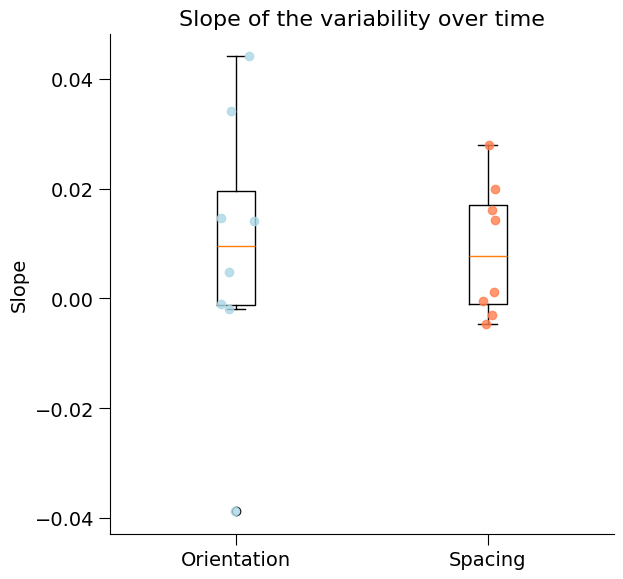

<Figure size 640x480 with 0 Axes>

In [54]:
# make a figure with the slopes for orientation and spacing
_, ax = plt.subplots(1, 1, figsize=(6.5, 6.5))

# make boxplot with slopes_orientation and slopes_spacing
ax.boxplot([slopes_orientation, slopes_spacing])
ax.set_xticklabels(['Orientation', 'Spacing'])
ax.set_ylabel('Slope', fontsize=14) 
ax.set_title('Slope of the variability over time', fontsize=16)


#add jitter
x = np.random.normal(1, 0.04, size=len(slopes_orientation))
ax.plot(x, slopes_orientation, 'o', color='lightblue', alpha=0.8)
x = np.random.normal(2, 0.04, size=len(slopes_spacing))
ax.plot(x, slopes_spacing, 'o', color='coral', alpha=0.8)


# set spines out
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
plt.tight_layout()

# save figure
plt.savefig(fig_directory + '/slopes.png', dpi=300)
# also in svg
plt.savefig(fig_directory + '/slopes.svg', dpi=300)

In [59]:
print(3.5/2)

1.75
